# Analytical DQPT for $n=2$

The partition function for $\beta = it$ with $n=2$ is given by

$$
    Z(t) = 2^{12}  \left(\frac{1}{8}  (1 + (\cos^4(2t)))^2 + \frac{1}{2}  \cos^4(2t)\right)
$$

The rate function then is

$$
    f(t) = -\frac{1}{12} \log(Z(t))
$$

The partition function for an arbitrary $\beta$ is just $\sum_E \rho(E) e^{-\beta E}$. If we know the exact density of states, which can be calculated for $n=2$, we can calculate $f(t)$. So, what I want to see is - what parts of the energy spectrum matters the most for $f(t)$? Let's start by first calculating the exact density of states.

In [219]:
using Graphs
using MetaGraphs
using HierarchicalLattices
using Plots
using LaTeXStrings
using ProgressMeter

gr()
default(dpi = 300, fontfamily = "Computer Modern", label = false, size = (900, 600), frame = :box, color = :greys)
resetfontsizes()
scalefontsizes(1.1)

In [13]:
index_to_state(i; n = 2) = (x -> x == 1 ? 1 : -1).(digits(i; base = 2, pad = 12))
function set_state!(lattice, statevec)
    for v in vertices(lattice)
        set_prop!(lattice, v, :val, statevec[v])
    end
end

set_state! (generic function with 1 method)

Lets test this function by making an order 2 lattice and setting it's state

In [28]:
O2 = diamond_ising_lattice(2, :zero)
DO2 = DiamondLattice(O2, 2)
set_state!(O2, index_to_state(2000))

In [26]:
for i in 0:2^12-1
    set_state!(O2, index_to_state(i))
    @assert all(index_to_state(i) .== (x -> x[:val]).(values(sort(O2.vprops))))
end

yay! it works. Now to generate the list of energies and convert that to a histogram

In [30]:
energies = zeros(2^12)
for i = 0:2^12-1
    set_state!(DO2.final_state, index_to_state(i))
    energies[i+1] = energy(DO2)
end

In [35]:
ρ(E) = count(==(E), energies)

ρ (generic function with 1 method)

In [189]:
function Z(β; E_range = -16:4:16)
    return sum([ρ(E)*exp(-β*E) for E in E_range])
end

Z (generic function with 1 method)

In [190]:
trange   = range(0, π, step = 0.01)
frange   = -1/12 .* log.(Z.(1im .* trange))
frange .-= frange[1];

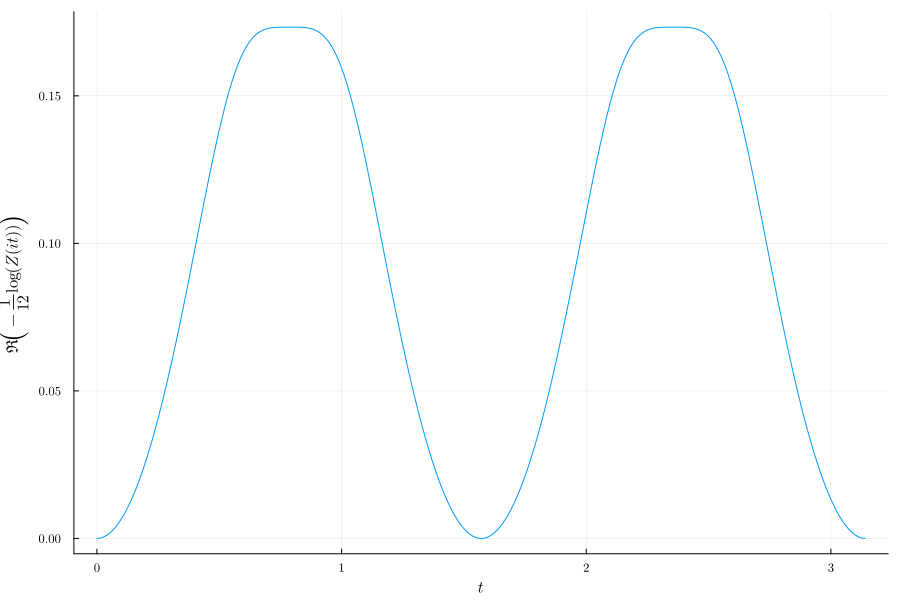

In [191]:
plot(trange, real.(frange), xlabel = L"t", ylabel = L"\Re\left(-\frac{1}{12}\log(Z(it))\right)")

Great. Now to sum over $E \in [-16, E_{max}]/4$ by increasing $E_{max}$ and plotting the rate function each time.

In [59]:
normal_Z = Animation()
@showprogress for Emax = -12:4:16
    Erange = -16:4:Emax
    Erange_cont = -16:0.1:Emax
    z(β) = Z(β; E_range = Erange)
    DoS = ρ.(Erange_cont)
    frange   = -1/12 .* log.(z.(1im .* trange))
    frange .-= frange[1];
    
    ratefunc = plot(trange, real.(frange), xlabel = L"t", ylabel = L"\Re\left(-\frac{1}{12}\log(Z(it))\right)", ylims = (0, 0.2))
    densityfunc = plot(Erange_cont, DoS, xlabel = L"E", ylabel = L"\rho(E)", xlims = (-16, 16), ylims = (0, 1900))
    
    fig = plot(ratefunc, densityfunc, layout = (2, 1), plot_title = L"E_{max} = %$Emax")
    frame(normal_Z, fig)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


In [61]:
mp4(normal_Z, "normal_Z.mp4", fps = 1);

[ Info: Saved animation to /home/cocoa_ug22/hierarchical_lattice_runs/normal_Z.mp4


In [194]:
function Z_sym(β; E_range = -16:4:16)
    return sum([ρ(E)*exp(-β*E) + ρ(E) * exp(β*E) for E in E_range])
end

Z_sym (generic function with 1 method)

In [174]:
symmetric_Z = Animation()
@showprogress for Emax = -12:4:16
    Erange = -16:4:Emax
    Erange_cont = -16:0.1:Emax
    z(β) = Z_sym(β; E_range = Erange)
    DoS = ρ.(Erange_cont)
    DoS_mirror = ρ.(-Erange_cont)
    frange   = -1/12 .* log.(z.(1im .* trange))
    frange .-= frange[1];
    
    ratefunc = plot(trange, real.(frange), xlabel = L"t", ylabel = L"\Re\left(-\frac{1}{12}\log(Z(it))\right)", ylims = (0, 0.2))
    densityfunc = plot(Erange_cont, DoS, xlabel = L"E", ylabel = L"\rho(E)", xlims = (-16, 16), ylims = (0, 1900))
    plot!(densityfunc, -Erange_cont, DoS_mirror)
    
    fig = plot(ratefunc, densityfunc, layout = (2, 1), plot_title = L"E_{max} = %$Emax")
    frame(symmetric_Z, fig)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


In [175]:
mp4(symmetric_Z, "symmetric_Z.mp4"; fps = 1);

[ Info: Saved animation to /home/cocoa_ug22/hierarchical_lattice_runs/symmetric_Z.mp4


In [212]:
function analytical_dqpt(x, n)
    if n == 0
        return real(-log(2) - log(cos(Complex(x)))) + log(2)
    elseif n == 1
        return abs(real(3/4 * log(2) + 1/4 * log(1 + (cos(2*Complex(x)))^2)) - log(2))
    elseif n == 2
        t = Complex(x)
        logZ = log( 2^12 * (1/8 * (1 + (cos(2*t)^4))^2 + 1/2 * (cos(2t))^4) )
        return real(-1/12 * logZ + log(2))
    end 
end

analytical_dqpt (generic function with 1 method)

0.15943437358000667

In [224]:
combined_Z = Animation()
@showprogress for Emax = -12:4:16
    Erange = -16:4:Emax
    Erange_cont = -16:0.1:Emax
    zsym(β) = Z_sym(β; E_range = Erange)
    z(β) = Z(β; E_range = Erange)
    
    DoS = ρ.(Erange_cont)
    DoS_mirror = ρ.(-Erange_cont)
    
    frange_normal = -1/12 .* log.(z.(1im .* trange))
    frange_normal .-= frange_normal[1]
    frange_sym = -1/12 .* log.(zsym.(1im .* trange))
    frange_sym .-= frange_sym[1]
    
    analytic_y = (x -> analytical_dqpt(x, 2)).(trange)
    
    ratefunc_normal = plot(trange, real.(frange_normal), xlabel = L"t", ylabel = "Rate Function", ylims = (0, 0.5), yguidefontsize = 12)
    ratefunc_sym = plot(trange, real.(frange_sym), xlabel = L"t", ylabel = "Rate Function (symmetric DoS)", ylims = (0, 0.5), yguidefontsize = 8)
    densityfunc = plot(Erange_cont, DoS, xlabel = L"E", ylabel = L"\rho(E)", xlims = (-16, 16), ylims = (0, 1900), yguidefontsize = 12)
    plot!(densityfunc, -Erange_cont, DoS_mirror, yguidefontsize = 8)
    
    plot!(ratefunc_normal, trange, analytic_y, linestyle = :dash, label = "Exact")
    plot!(ratefunc_sym, trange, analytic_y, linestyle = :dash, label = "Exact")
    
    fig = plot(ratefunc_normal, ratefunc_sym, densityfunc, layout = (3, 1), plot_title = L"E_{max} = %$Emax")
    frame(combined_Z, fig)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


In [225]:
combined_Z

Animation("/tmp/jl_motWOd", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png"])

In [215]:
mp4(combined_Z, "combined_ratefunc.mp4"; fps = 1)

[ Info: Saved animation to /home/cocoa_ug22/hierarchical_lattice_runs/combined_ratefunc.mp4


Plots.AnimatedGif("/home/cocoa_ug22/hierarchical_lattice_runs/combined_ratefunc.mp4")

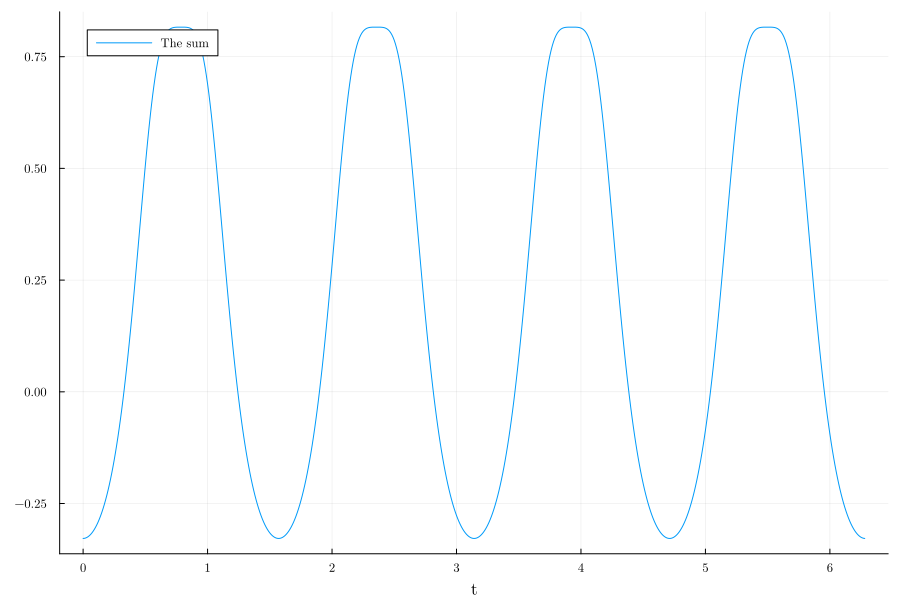

In [211]:
let
    E_range = -16:4:0
    rho(t) = ρ(t; E_range = E_range)
    zexact(t) = ρ(0) + ρ(4) * cos(t*4) + ρ(8) * cos(t * 8) + ρ(12) * cos(t * 12) + ρ(16) * cos(t * 16) 
    trange = range(0, 2π, step = 0.01)
    plot(trange, log.(zexact.(trange)) .- real.(log.(Z.(1im * trange))), xlabel = "t", label = "The sum")
#     plot!(trange, , label = "Partition function")
end

In [180]:
combined_Z_nolog = Animation()
@showprogress for Emax = -12:4:16
    Erange = -16:4:Emax
    Erange_cont = -16:0.1:Emax
    zsym(β) = Z_sym(β; E_range = Erange)
    z(β) = Z(β; E_range = Erange)
    
    DoS = ρ.(Erange_cont)
    DoS_mirror = ρ.(-Erange_cont)
    
    frange_normal = -2^(-12) .* z.(1im .* trange)
    frange_normal .-= frange_normal[1]
    frange_sym = -2^(-12) .* zsym.(1im .* trange)
    frange_sym .-= frange_sym[1]
    
    ratefunc_normal = plot(trange, real.(frange_normal), xlabel = L"t", ylabel = L"-\Re(2^{-12} Z(it))", yguidefontsize = 12, ylims = (0, 1))
    ratefunc_sym = plot(trange, real.(frange_sym), xlabel = L"t", ylabel = L"-\Re(2^{-12} Z(it)) \textrm{ (Symmetric)}", yguidefontsize = 8, ylims = (0, 1))
    densityfunc = plot(Erange_cont, DoS, xlabel = L"E", ylabel = L"\rho(E)", xlims = (-16, 16), ylims = (0, 1900), yguidefontsize = 12)
    plot!(densityfunc, -Erange_cont, DoS_mirror, yguidefontsize = 8)
    
    fig = plot(ratefunc_normal, ratefunc_sym, densityfunc, layout = (3, 1), plot_title = L"E_{max} = %$Emax")
    frame(combined_Z_nolog, fig)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


In [218]:
combined_Z_nolog

Animation("/tmp/jl_cI9SbP", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png"])

In [182]:
mp4(combined_Z_nolog, "Partitionfunction.mp4"; fps = 1)

[ Info: Saved animation to /home/cocoa_ug22/hierarchical_lattice_runs/Partitionfunction.mp4


Plots.AnimatedGif("/home/cocoa_ug22/hierarchical_lattice_runs/Partitionfunction.mp4")

In [226]:
ratefunc_anim = Animation()
@showprogress for t in trange
    E_values = -16:4:16
    Z_terms = ρ.(E_values) .* exp.(-1im*t .* E_values)
    
    f = Z_terms
    
    fig = plot(E_values, real.(f), xlabel = L"E", ylabel = L"\Re\left(\rho(E)e^{-itE}\right)", style = :dash, markershape = :circ)
    
    trange   = range(0, π, step = 0.01)
    frange   = -1/12 .* log.(Z.(1im .* trange))
    frange .-= frange[1]
    
    ratefunc_fig = plot(trange, real.(frange), xlabel = L"t", ylabel = L"\Re\left(-\frac{1}{12}\log(Z(it))\right)")
    vline!([t])
    
    frame(ratefunc_anim, plot(fig, ratefunc_fig, layout = (2, 1), plot_title = "t = $(round(t, digits=2))"))
end

Progress: 100%|█████████████████████████████████████████| Time: 0:01:22


In [227]:
ratefunc_anim

Animation("/tmp/jl_YJq2wz", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "000306.png", "000307.png", "000308.png", "000309.png", "000310.png", "000311.png", "000312.png", "000313.png", "000314.png", "000315.png"])

In [228]:
mp4(ratefunc_anim)

[ Info: Saved animation to /home/cocoa_ug22/hierarchical_lattice_runs/tmp.mp4


Plots.AnimatedGif("/home/cocoa_ug22/hierarchical_lattice_runs/tmp.mp4")

In [144]:
let
    E_range = -16:4:-8
    DoS = ρ.(E_range)
    DoS_flipped = ρ.(-E_range)
    
    log(sum((DoS_flipped .* exp.(0.5im .* E_range)))) - log(sum((DoS .* exp.(-0.5im .* E_range))))
end

0.0 + 4.457866461794207im

In [220]:
growfromcenter = Animation()
@showprogress for Emax = 0:4:16
    Erange = -Emax:4:Emax
    Erange_cont = -Emax:0.1:Emax
    
    z(β) = Z(β; E_range = Erange)
    
    DoS = ρ.(Erange_cont)
    frange   = -1/12 .* log.(z.(1im .* trange))
    frange .-= frange[1];
    
    ratefunc = plot(trange, real.(frange), xlabel = L"t", ylabel = L"\Re\left(-\frac{1}{12}\log(Z(it))\right)", ylims = (0, 0.2))
    densityfunc = plot(Erange_cont, DoS, xlabel = L"E", ylabel = L"\rho(E)", xlims = (-16, 16), ylims = (0, 1900))
    
    fig = plot(ratefunc, densityfunc, layout = (2, 1), plot_title = L"E_{max} = %$Emax")
    frame(growfromcenter, fig)
end;

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


In [221]:
growfromcenter

Animation("/tmp/jl_Gb5zfq", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png"])

In [78]:
mp4(growfromcenter, "growfromcenter.mp4"; fps = 1);

[ Info: Saved animation to /home/cocoa_ug22/hierarchical_lattice_runs/growfromcenter.mp4
